In [1]:
import numpy as np
import pandas as pd
import pennylane as qml
from susy_qm import calculate_Hamiltonian
from qiskit.quantum_info import SparsePauliOp
import itertools

from qutip import Qobj, concurrence, ptrace

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
psi = np.array([1/2, 1/2, 1/2, 1/2])
psi = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])

psi_q = Qobj(psi, dims=[[2, 2], [1, 1]])
rho = psi_q * psi_q.dag()
  
entropy = concurrence(rho)
entropy

np.float64(0.9999999999999998)

In [2]:
potential = 'DW'
cutoffs = [2, 4, 8, 16, 32, 64, 128,256]

# 9 qubits for 256
data = {}
data_qu = int(np.log2(max(cutoffs))) + 1
for qubit1 in range(1, data_qu):
        for qubit2 in range(qubit1 + 1, data_qu):
                data[f"q{qubit1}{qubit2}"] = []


for cutoff in cutoffs:

    print(f"Running for cutoff: {cutoff}")

    #calculate Hamiltonian and expected eigenvalues
    H = calculate_Hamiltonian(cutoff, potential)

    eigenvalues, eigenvectors = np.linalg.eig(H)
    min_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_index]
    min_eigenvector = np.asarray(eigenvectors[:, min_index])

    hamiltonian = SparsePauliOp.from_operator(H)
    num_qubits = hamiltonian.num_qubits

    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
    rho = psi * psi.dag()

    cutoff_qubits = []
    for qubit1 in range(1, num_qubits):
        for qubit2 in range(qubit1 + 1, num_qubits):
            
            rho_2q = ptrace(rho, [qubit1, qubit2])
            c = concurrence(rho_2q)

            col_name = f"q{qubit1}{qubit2}"
            data[col_name].append(c)

            cutoff_qubits.append(col_name)

    nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
    for key in nan_qubits:
        data[key].append(np.nan)

data['cutoffs'] = cutoffs.copy()
#data           

Running for cutoff: 2
Running for cutoff: 4
Running for cutoff: 8
Running for cutoff: 16
Running for cutoff: 32
Running for cutoff: 64
Running for cutoff: 128
Running for cutoff: 256


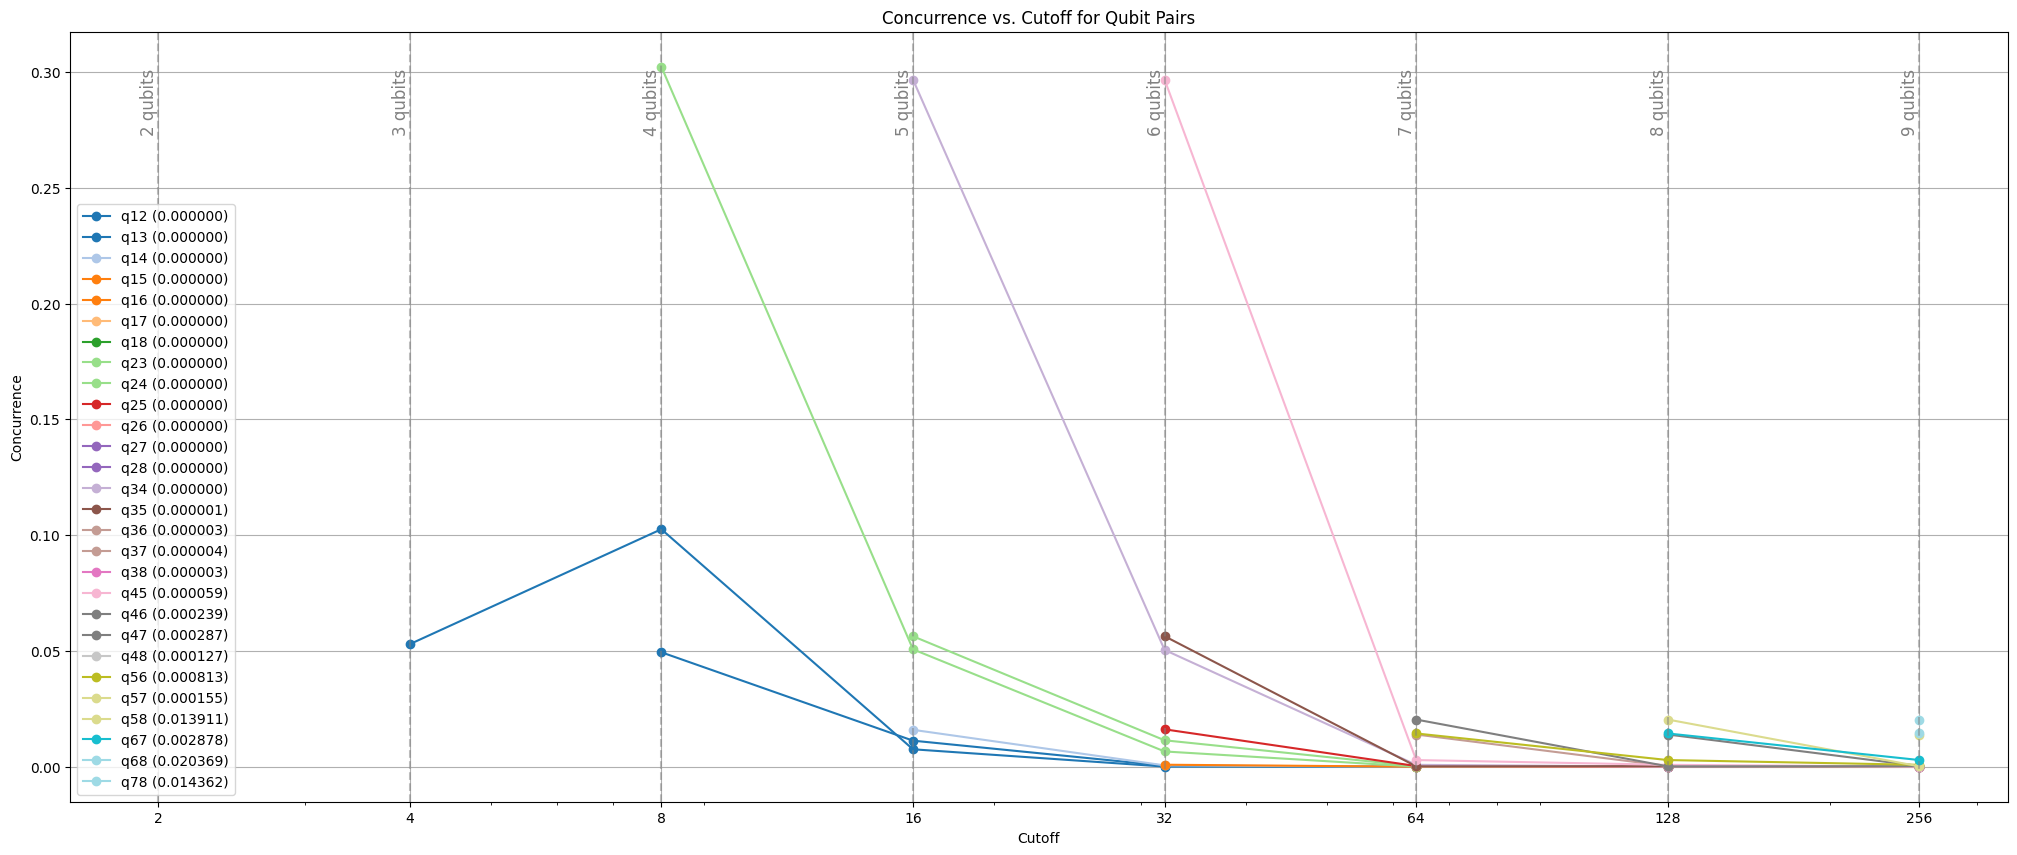

In [3]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key} ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Concurrence")
plt.title("Concurrence vs. Cutoff for Qubit Pairs")
plt.legend()
plt.grid()
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\ConcurrencePlots\plot_{}".format(potential))

In [8]:
d = data.copy()
cutoffs = d.pop('cutoffs')
ordered_data = {cutoff: sorted(((k, v[i]) for k, v in d.items()), key=lambda x: (np.isnan(x[1]), -x[1])) for i, cutoff in enumerate(cutoffs)}

df = pd.DataFrame({
    cutoff: [f"{pair[0]} ({pair[1]:.6f})" if not np.isnan(pair[1]) else f"{pair[0]} (nan)" 
             for pair in ordered_data[cutoff]]
    for cutoff in cutoffs
})

In [5]:
df

,2,4,8,16,32,64,128,256
0,q12 (nan),q12 (0.000000),q12 (0.020425),q23 (0.066269),q34 (0.065108),q45 (0.065123),q56 (0.065123),q67 (0.065123)
1,q13 (nan),q13 (nan),q13 (0.000000),q13 (0.033316),q24 (0.027423),q35 (0.027363),q46 (0.027363),q57 (0.027363)
2,q14 (nan),q14 (nan),q23 (0.000000),q12 (0.030037),q23 (0.021220),q34 (0.021090),q45 (0.021090),q56 (0.021090)
3,q15 (nan),q15 (nan),q14 (nan),q14 (0.000000),q13 (0.005455),q24 (0.005384),q35 (0.005384),q46 (0.005384)
4,q16 (nan),q16 (nan),q15 (nan),q24 (0.000000),q14 (0.003965),q25 (0.003993),q36 (0.003993),q47 (0.003993)
5,q17 (nan),q17 (nan),q16 (nan),q34 (0.000000),q12 (0.003410),q23 (0.002987),q34 (0.002987),q45 (0.002987)
6,q18 (nan),q18 (nan),q17 (nan),q15 (nan),q15 (0.000000),q14 (0.000474),q25 (0.000473),q36 (0.000473)
7,q23 (nan),q23 (nan),q18 (nan),q16 (nan),q25 (0.000000),q15 (0.000358),q26 (0.000357),q37 (0.000357)
8,q24 (nan),q24 (nan),q24 (nan),q17 (nan),q35 (0.000000),q13 (0.000288),q24 (0.000288),q35 (0.000288)
9,q25 (nan),q25 (nan),q25 (nan),q18 (nan),q45 (0.000000),q12 (0.000029),q23 (0.000027),q34 (0.000027)
